# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

## 1. Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**Data Mining Goals**
- To find which features in used cars are the most relevant in determining price of cars
- To create a linear regression model that can predict the price of used cars based on the car features
- Cross-validate model prediction with actual data to see if the errors are acceptable
- Compare errors of different models to see which one works the best
- To make recommnedation to car dealers on how much a particular used car should be priced based on the ML model

## 2. Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### 2.1 Initial Inspection
- Gather and describe the data
- Load the data
- Examine sample rows to see which features are available and data types
- See how much data are missing and determine which features to focus on for data analysis


In [1]:
import zipfile
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge,  Lasso

pd.options.display.float_format = '{:.4f}'.format
sns.set_palette('Pastel1')

In [4]:
# Load the dataset
zip_file_path = 'data/vehicles.csv.zip' 
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('data')
vehicles_raw = pd.read_csv('data/vehicles.csv')

In [5]:
# Examine a few rows
vehicles_raw.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
70311,7315319245,yuba-sutter,19999,2011.0000,chevrolet,silverado 1500 ls,excellent,8 cylinders,gas,93105.0000,clean,automatic,1GCRCREA9BZ104747,NaN,NaN,truck,NaN,ca
209804,7304140210,southwest michigan,14990,2015.0000,honda,civic lx coupe 2d,good,NaN,gas,77726.0000,clean,other,2HGFG3A55FH510450,fwd,NaN,coupe,red,mi
242559,7309963372,raleigh / durham / CH,18590,2012.0000,mercedes-benz,m-class ml 350,good,6 cylinders,gas,95872.0000,clean,automatic,4JGDA5HB0CA038937,NaN,NaN,other,silver,nc
350396,7314755943,rapid city / west SD,5700,2009.0000,toyota,camry,good,4 cylinders,gas,153171.0000,salvage,automatic,NaN,fwd,mid-size,sedan,white,sd
172327,7316227610,louisville,7500,1997.0000,ford,f-150 xl,like new,6 cylinders,gas,56000.0000,clean,manual,NaN,rwd,full-size,pickup,blue,ky


In [201]:
# Look at statistics of numerical features 
vehicles_raw.describe()

,id,price,year,odometer
count,426880.0000,426880.0000,425675.0000,422480.0000
mean,7311486634.2243,75199.0332,2011.2352,98043.3314
std,4473170.4126,12182282.1736,9.4521,213881.5008
min,7207408119.0000,0.0000,1900.0000,0.0000
25%,7308143339.2500,5900.0000,2008.0000,37704.0000
50%,7312620821.0000,13950.0000,2013.0000,85548.0000
75%,7315253543.5000,26485.7500,2017.0000,133542.5000
max,7317101084.0000,3736928711.0000,2022.0000,10000000.0000


In [202]:
# Look at number of rows and data types of features
vehicles_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### 2.2 Data Description

**Numerical Data**
- ID: Car data entry ID
- Price: Listed price of the car
- Year: Car purchased year
- Odometer: total mileage traveled

**Categorical Data**
- Region: Region of a state where the car is listed
- Manufacturer: Car manufacturer
- Model: Car model
- Condition: Condition of car - new, like new, excellent, good, fair, salvage
- Cylinders:  3 cylinders, 4 cylinders, 5 cylinders, 6 cylinders, 8 cylinders, 10 cylinders, 12 cylinders, other
- Fuel: gas, diesel, hybrid, electric
- Title Status: clean, rebuilt, salvage, lien, missing, parts only
- Transmission: automatic, manual, other
- VIN: vehicle indentification number
- Drive: 4wd, fwd, rwd
- Size: full-size, mid-size, compact, sub-compact  
- Type: sedan, SUV, pickup, truck, other, coupe, hatchback, wagon, van, convertible, mini-van, offroad, bus
- Paint color: white, black, silver, blue, red, grey, green, custom, brown, yellow, orange, purple
- State: State where the car is listed



In [203]:
# Examine null rows
vehicles_raw.isnull().sum().sort_values()

id                   0
price                0
state                0
region               0
year              1205
transmission      2556
fuel              3013
odometer          4400
model             5277
title_status      8242
manufacturer     17646
type             92858
paint_color     130203
drive           130567
VIN             161042
condition       174104
cylinders       177678
size            306361
dtype: int64

### 2.3 Inital Dropping of Unnecessary Columns
To focus on relevant features before taking a first look of the data, drop irrelevant columns first.

Columns with null values of about 25% or more (>106,150) of the original dataset will be dropped.
  Column Name (No. Null Entries)
- `paint_color` (130203)
- `drive`(130567)
- `VIN` (161042)
- `condition`           (174104)
- `cylinders`           (177678)
- `size`                (306361)

Irrelevat columns will be dropped too.
- `id` - It cannot be used as index             
- `state` - Irrelevant to car condition
- `region` - Irrelevant to car condition
- `model` - It has too many distinct values, which creates too much noise

In [204]:
# List of columns to drop
columns_to_drop = ['paint_color', 'drive', 'VIN', 'condition','cylinders', 'size', 'id', 'state', 'region', 'model']

In [205]:
# Drop columns
df_clean = vehicles_raw
df_clean = df_clean.drop(columns_to_drop, axis=1)
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   fuel          423867 non-null  object 
 4   odometer      422480 non-null  float64
 5   title_status  418638 non-null  object 
 6   transmission  424324 non-null  object 
 7   type          334022 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 26.1+ MB


In [206]:
# Create lists of column names
cat_cols = df_clean.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

### 2.4 Univariate Numeric Features Analysis

Check distributions of numeric data.

In [207]:
# Check statistics of numercal data of the new dataframe
df_clean.describe()

,price,year,odometer
count,426880.0000,425675.0000,422480.0000
mean,75199.0332,2011.2352,98043.3314
std,12182282.1736,9.4521,213881.5008
min,0.0000,1900.0000,0.0000
25%,5900.0000,2008.0000,37704.0000
50%,13950.0000,2013.0000,85548.0000
75%,26485.7500,2017.0000,133542.5000
max,3736928711.0000,2022.0000,10000000.0000


The standard deviataions are really large for `price` and `odometer`, and the minimum value for both is 0, which does not make sense. Plot to examine.

In [208]:
# Check number of numerical columns for setting up the plot
len(num_cols)

3

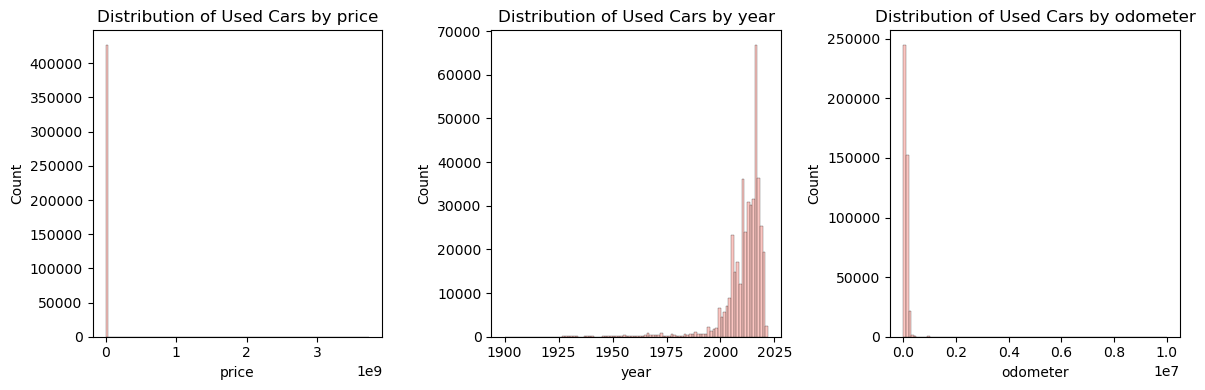

In [209]:
# Plot the distribution of the numerical data to visualize
fig,_axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes=_axes.flatten()
#plt.subplots_adjust(wspace=.3, hspace=0.5)
for i in range (len(num_cols)):
    axes[i] = sns.histplot(df_clean, x = num_cols[i], ax=axes[i], bins=100)
    axes[i].set_title(f'Distribution of Used Cars by {num_cols[i]}')
    #axes[i].set_xlabel('Price')
    #axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()
# fig.delaxes(axes[3])


The distributions for the numerical features are highly skewed. Outliers need to be removed.
 - Remove values which are not reasonable
 - Remove outliers by IQR method

Car price below 1000 dollars, and odometer reading below 10000 miles are not reasonable. Drop those rows.

In [210]:
# Drop unreasonable `price` rows and `odometer` rows
df_clean = df_clean[df_clean['price'] >1000]
df_clean = df_clean[df_clean['odometer'] >10000] 

In [211]:
# Remove outliers for numerical columns using IQR method
for i in range(len(num_cols)):
    Q1 = df_clean[num_cols[i]].quantile(0.25)
    Q3 = df_clean[num_cols[i]].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[num_cols[i]] >= lower_bound) & (df_clean[num_cols[i]] <= upper_bound)]
    i=i+1

# Check resulting data after outliers and unreasonable data rows are removed
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328332 entries, 27 to 426879
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         328332 non-null  int64  
 1   year          328332 non-null  float64
 2   manufacturer  319144 non-null  object 
 3   fuel          326367 non-null  object 
 4   odometer      328332 non-null  float64
 5   title_status  322859 non-null  object 
 6   transmission  327025 non-null  object 
 7   type          261006 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 22.5+ MB


In [212]:
# Check the statistics of numerical features again
df_clean.describe()

,price,year,odometer
count,328332.0000,328332.0000,328332.0000
mean,17958.8146,2012.1717,98415.7525
std,12060.1573,5.2695,58165.1225
min,1003.0000,1996.0000,10001.0000
25%,7950.0000,2009.0000,47700.0000
50%,15000.0000,2013.0000,94500.0000
75%,25999.0000,2016.0000,139398.0000
max,55605.0000,2022.0000,279000.0000


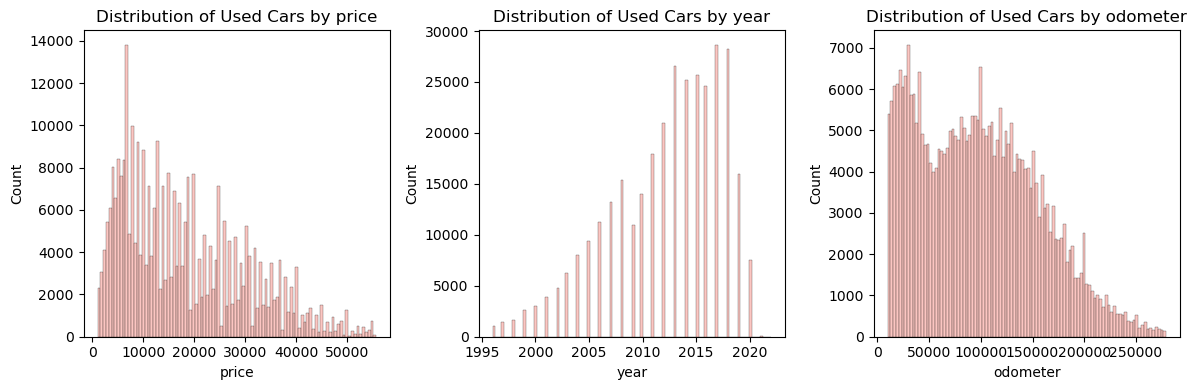

In [213]:
# Plot the distribution of numerical data to see if the graphs look reasonable
fig,_axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes=_axes.flatten()
#plt.subplots_adjust(wspace=.3, hspace=0.5)
for i in range (len(num_cols)):
    axes[i] = sns.histplot(df_clean, x = num_cols[i], ax=axes[i], bins=100)
    axes[i].set_title(f'Distribution of Used Cars by {num_cols[i]}')
    #axes[i].set_xlabel('Price')
    #axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()
# fig.delaxes(axes[3])

The disbribution now look more reasonable.

### 2.5 Categorical Feature Analysis

In [214]:
# Remove `manufacturer` from the categorical column list to plot it separately 
cat_cols.remove('manufacturer')
# Get size of the column list to set up plot
len(cat_cols)

4

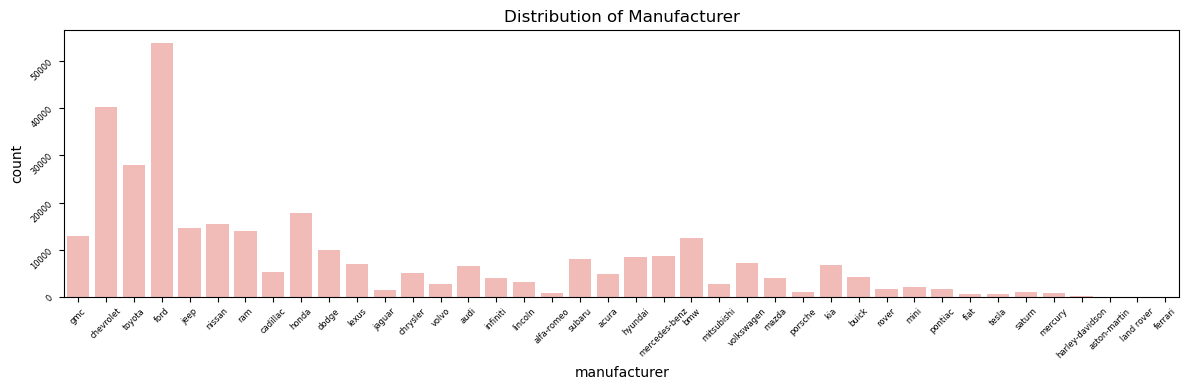

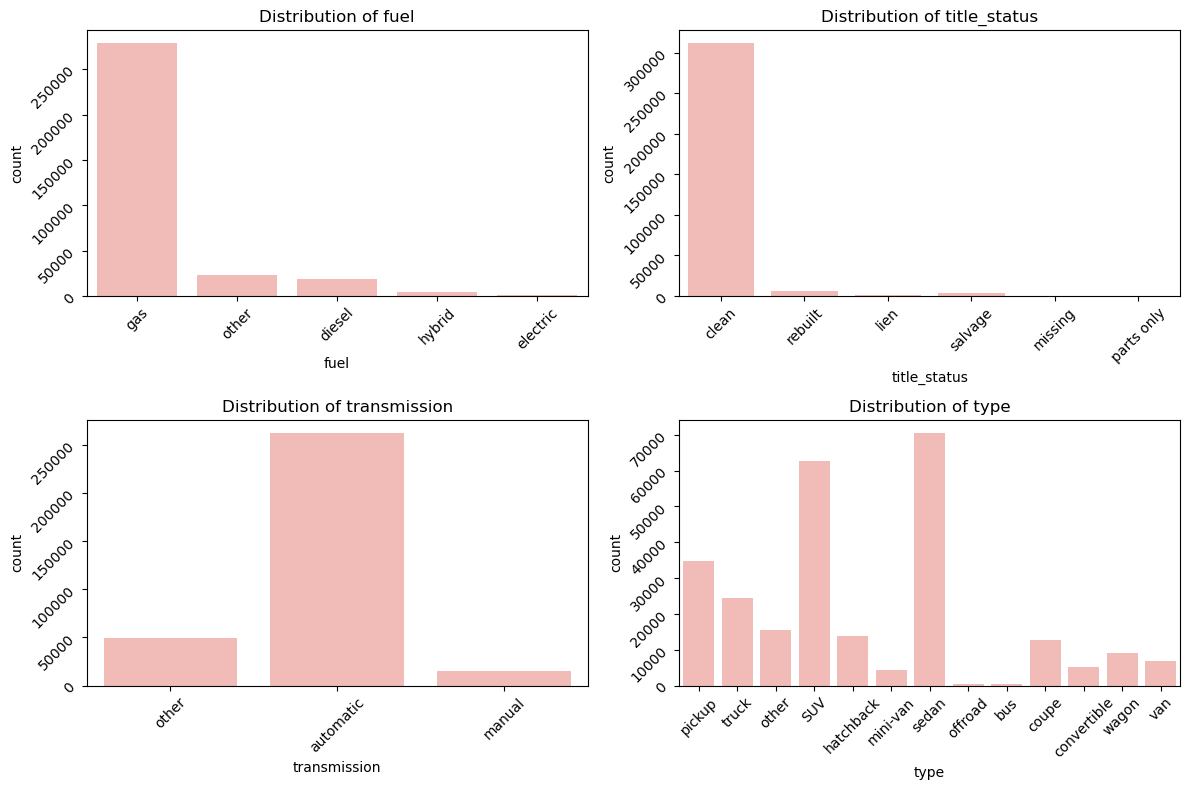

In [220]:
# Plot `manufacturer` separately

plt.figure(figsize=(12, 4)) # width=10 inches, height=6 inches
ax = sns.countplot(df_clean, x = 'manufacturer') 
ax.set_title("Distribution of Manufacturer")
ax.tick_params(labelrotation=45, labelsize=6)
plt.tight_layout()
plt.show()

# Plot the rest of the categorical features
fig,_axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes=_axes.flatten()
#plt.subplots_adjust(wspace=.3, hspace=0.5)
for i in range (len(cat_cols)):
    axes[i] = sns.countplot(df_clean, x = cat_cols[i], ax=axes[i])
    axes[i].set_title(f'Distribution of {cat_cols[i]}')
    axes[i].tick_params(labelrotation=45)
    #axes[i].set_xlabel('Price')
    #axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

The columns `fuel` and `title_status` are mostly the same values. They can be dropped. 
- `gas` accounts for 85% of `fuel`
- `clean` accounts for 95% of `title_status`

In [221]:
# Count the values in `fuel` amd `title_status` columns
print (df_clean['fuel'].value_counts())
print()
print (df_clean['title_status'].value_counts())
print()
print ("Total number of rows is", len(df_clean))

fuel
gas         279072
other        22807
diesel       18823
hybrid        4402
electric      1263
Name: count, dtype: int64

title_status
clean         311764
rebuilt         6485
salvage         3221
lien            1217
missing          124
parts only        48
Name: count, dtype: int64

Total number of rows is 328332


In [222]:
# Drop `fuel` and `title_status`
df_clean = df_clean.drop(["fuel", "title_status"], axis=1)

### 2.6 Bivariate Analysis
Visualize relationships between `price` and other features.

Text(0.5, 1.0, 'Correlations between Numerical Features ')

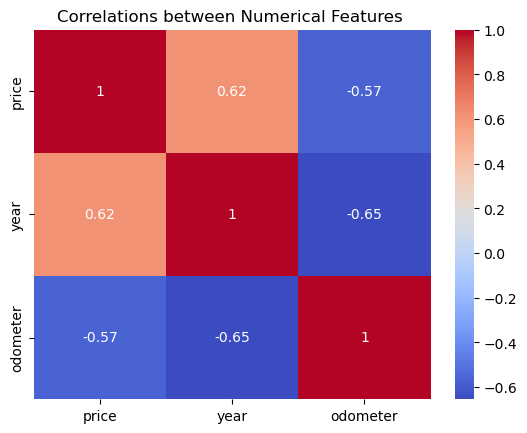

In [223]:
# Compute the correlation matrix for numerical data
correlation_matrix = df_clean[num_cols].corr()

# Plot the heatmap
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
ax.set_title("Correlations between Numerical Features ")

`year` is positively correlated to `price`, and `odometer` is negatively correlated to `price`.

In [224]:
# Create categorical column list for plotting. Plot `manufacturer` separately
cat_cols = df_clean.select_dtypes(include=["object", "category"]).columns.tolist()
cat_cols.remove('manufacturer')
cat_cols

['transmission', 'type']

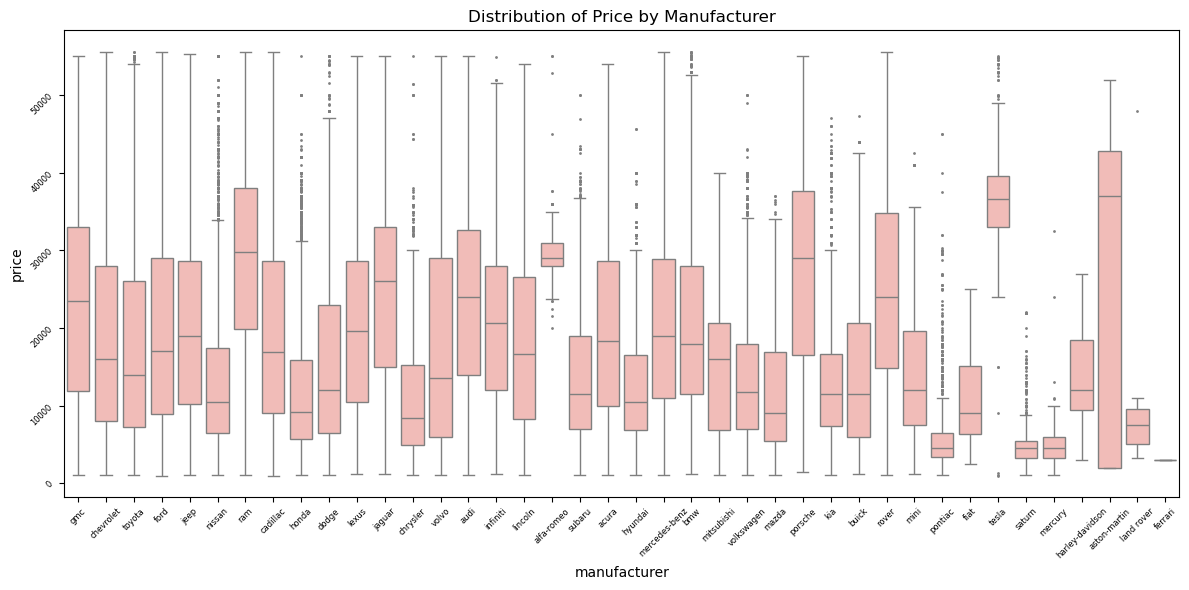

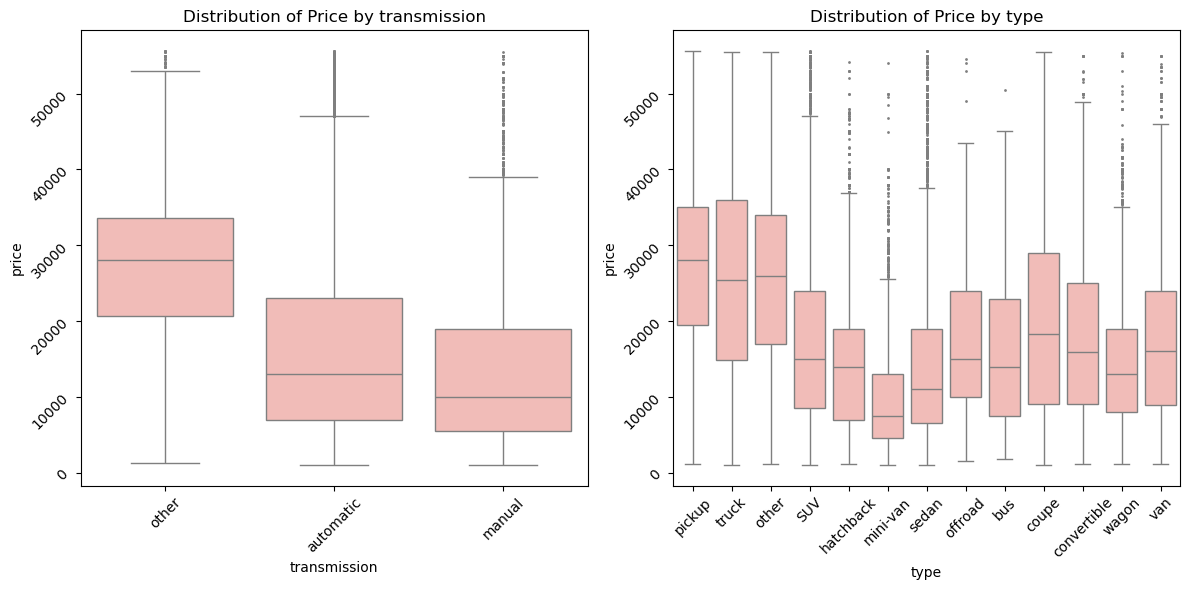

In [180]:
# Plot price distribution by `manufacturer` 
plt.figure(figsize=(12, 6)) # width=10 inches, height=6 inches
ax = sns.boxplot(df_clean, x = 'manufacturer', y = 'price', fliersize=1) 
ax.set_title("Distribution of Price by Manufacturer")
ax.tick_params(labelrotation=45, labelsize=6)
plt.tight_layout()
plt.show()

# plot price distribution for other categorical features
fig,_axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes=_axes.flatten()
#plt.subplots_adjust(wspace=.3, hspace=0.5)
for i in range (len(cat_cols)):
    axes[i] = sns.boxplot(df_clean, x = cat_cols[i], y = 'price', ax=axes[i], fliersize=1)
    axes[i].set_title(f'Distribution of Price by {cat_cols[i]}')
    axes[i].tick_params(labelrotation=45)
    #axes[i].set_xlabel('Price')
    #axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

The boxplots shows that the price range differs for different values of the categorical features.

## 3. Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

Some of the data were already dropped following initial exploratory analysis.

What remains to be done:
- Check and fill missing values
- Ecocde categorical features
- Scale numberic features

### 3.1 Check for Missing Values

In [181]:
# Check null values
df_clean.isnull().sum().sort_values() 

price               0
year                0
odometer            0
transmission     1307
manufacturer     9188
type            67326
dtype: int64

### 3.2 Fill in Missing Values
- Fill in missing values for categorical features using MODE

In [ ]:
# Find MODE for the features
df_clean.mode()

,price,year,manufacturer,odometer,transmission,type
0,6995,2017.0000,ford,200000.0000,automatic,sedan


In [184]:
# Fill in missing values
df_clean['manufacturer']= df_clean['manufacturer'].fillna('ford')
df_clean['transmission'] = df_clean['transmission'].fillna('automatic')
df_clean['type']= df_clean['type'].fillna('sedan')

In [185]:
# Check the resulting data frame
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328332 entries, 27 to 426879
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         328332 non-null  int64  
 1   year          328332 non-null  float64
 2   manufacturer  328332 non-null  object 
 3   odometer      328332 non-null  float64
 4   transmission  328332 non-null  object 
 5   type          328332 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 17.5+ MB


### 3.3 Encode Categorical Features

There does not appear to be strong correlations between the categorical features and price. I will not use these features in the subsequent modeling.

In [186]:
# Reset index of the new data frame
df_clean=df_clean.reset_index(drop=True)
df_clean

,price,year,manufacturer,odometer,transmission,type
0,33590,2014.0000,gmc,57923.0000,other,pickup
1,22590,2010.0000,chevrolet,71229.0000,other,pickup
2,39590,2020.0000,chevrolet,19160.0000,other,pickup
3,30990,2017.0000,toyota,41124.0000,other,pickup
4,15000,2013.0000,ford,128000.0000,automatic,truck
...,...,...,...,...,...,...
328327,33590,2018.0000,lexus,30814.0000,automatic,sedan
328328,23590,2019.0000,nissan,32226.0000,other,sedan
328329,30590,2020.0000,volvo,12029.0000,other,sedan
328330,28990,2018.0000,lexus,30112.0000,other,sedan


In [187]:
# Use One Hot Encoding to populate categorical features
cat_cols = df_clean.select_dtypes(include=["object", "category"]).columns.tolist()
ohe = OneHotEncoder(sparse_output = False, drop='if_binary')
encoded_features = ohe.fit_transform(df_clean[cat_cols])
encoded_df=pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(cat_cols))
df_encoded=pd.concat([df_clean, encoded_df], axis=1)
df_encoded=df_encoded.drop(cat_cols, axis=1)

In [188]:
# Check resulting data frame
df_encoded.head()

,price,year,odometer,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,...,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
0,33590,2014.0000,57923.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
1,22590,2010.0000,71229.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
2,39590,2020.0000,19160.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
3,30990,2017.0000,41124.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
4,15000,2013.0000,128000.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


### 3.4 Scale Data

In [190]:
# Apply Standard Scaler
scaler = StandardScaler()
scaled = scaler.fit_transform(df_encoded)
scaled_df = pd.DataFrame(scaled, columns=df_encoded.columns)
scaled_df.head()

,price,year,odometer,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,...,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
0,1.2961,0.3470,-0.6962,-0.1229,-0.0466,-0.0058,-0.1423,-0.1990,-0.1123,-0.1270,...,-0.2015,-0.2096,-0.1146,-0.0334,-0.2234,2.9004,-0.8512,-0.2836,-0.1449,-0.1686
1,0.3840,-0.4121,-0.4674,-0.1229,-0.0466,-0.0058,-0.1423,-0.1990,-0.1123,-0.1270,...,-0.2015,-0.2096,-0.1146,-0.0334,-0.2234,2.9004,-0.8512,-0.2836,-0.1449,-0.1686
2,1.7936,1.4856,-1.3626,-0.1229,-0.0466,-0.0058,-0.1423,-0.1990,-0.1123,-0.1270,...,-0.2015,-0.2096,-0.1146,-0.0334,-0.2234,2.9004,-0.8512,-0.2836,-0.1449,-0.1686
3,1.0805,0.9163,-0.9850,-0.1229,-0.0466,-0.0058,-0.1423,-0.1990,-0.1123,-0.1270,...,-0.2015,-0.2096,-0.1146,-0.0334,-0.2234,2.9004,-0.8512,-0.2836,-0.1449,-0.1686
4,-0.2453,0.1572,0.5086,-0.1229,-0.0466,-0.0058,-0.1423,-0.1990,-0.1123,-0.1270,...,-0.2015,-0.2096,-0.1146,-0.0334,-0.2234,-0.3448,-0.8512,3.5260,-0.1449,-0.1686


## 4. Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### 4.1 Split Data into Training and Testing Data 

In [ ]:
# Generate train / test data
df = scaled_df
df_X = df.drop(['price'], axis = 1)
df_y = df['price']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size = 0.3)

### 4.2 Ridge Regression Model with Grid Search Cross-Validation

In [192]:
# Create a ridge regression model with alpha values
ridge = Ridge()
param_dict = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000]}

ridge_grid = GridSearchCV(ridge, param_grid=param_dict)
ridge_grid.fit(X_train, y_train)

ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)

ridge_best_alpha = ridge_grid.best_params_
ridge_coefs = ridge_grid.best_estimator_.coef_

print(f'Ridge Train MSE: {ridge_train_mse}')
print(f'Ridge Test MSE: {ridge_test_mse}')
print(f'Grid Search CV Best Alpha for Ridge Regression Model: {list(ridge_best_alpha.values())[0]}')

Ridge Train MSE: 0.37691570907738253
Ridge Test MSE: 0.3763044859290995
Grid Search CV Best Alpha for Ridge Regression Model: 100.0


Examine the coefficients derived by the ridge regression model.

In [193]:
# Construct a pretty table
ridge_coefs_table=pd.DataFrame(ridge_coefs)
ridge_coefs_table.index=X_train.columns
ridge_coefs_table.columns=['Ridge Coefficients']
ridge_coefs_table_sorted = ridge_coefs_table.sort_values(by='Ridge Coefficients', ascending=False)

In [ ]:
# Check the top features attributing to increased price
ridge_coefs_table_sorted.head(10)

,Ridge Coefficients
year,0.4224
type_truck,0.1666
type_pickup,0.1404
manufacturer_ram,0.0854
manufacturer_gmc,0.0546
manufacturer_lexus,0.0527
manufacturer_porsche,0.0504
manufacturer_tesla,0.0468
manufacturer_ford,0.0424
manufacturer_mercedes-benz,0.0415


In [ ]:
# Check the top features attributing to decreased price
ridge_coefs_table_sorted.tail(10)

,Ridge Coefficients
manufacturer_mazda,-0.0419
manufacturer_chrysler,-0.0432
manufacturer_honda,-0.0481
manufacturer_volkswagen,-0.0583
manufacturer_kia,-0.0790
manufacturer_hyundai,-0.0831
manufacturer_nissan,-0.0915
type_hatchback,-0.1030
type_sedan,-0.1071
odometer,-0.2706


The ridge regression model shows that the most important attributes of used cars affecting pricing are `year` followed by `odometer`. Newer cars are priced higher, and cars with more mileage are priced lower. Types of cars also influence the prices, for example, trucks would be priced higher than sedans. Cars from certain manufactueres are also valued more than others.

### 4.3 LASSO Regression Model with Grid Search Cross-Validation

In [ ]:
# Create LASSO model with GridSearchCV
lasso = Lasso()
param_dict = {'alpha': [0.001, 0.01, 0.1, 1]}

lasso_grid = GridSearchCV(lasso, param_grid=param_dict)
lasso_grid.fit(X_train, y_train)

lasso_train_preds = lasso_grid.predict(X_train)
lasso_test_preds = lasso_grid.predict(X_test)
lasso_train_mse = mean_squared_error(y_train, lasso_train_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_test_preds)

lasso_best_alpha = lasso_grid.best_params_
lasso_coefs = lasso_grid.best_estimator_.coef_

print(f'Lasso Train MSE: {lasso_train_mse}')
print(f'Lasso Test MSE: {lasso_test_mse}')
print(f'Grid Search CV Best Alpha for LASSO Regression Model: {list(lasso_best_alpha.values())[0]}')

Lasso Train MSE: 0.3778646908997579
Lasso Test MSE: 0.3742468119377179
Grid Search CV Best Alpha for LASSO Regression Model: 0.001


In [ ]:
# Construct pretty table
lasso_coefs_table=pd.DataFrame(lasso_coefs)
lasso_coefs_table.index=X_train.columns
lasso_coefs_table.columns=['LASSO Coefficients']
lasso_coefs_table_sorted = lasso_coefs_table.sort_values(by='LASSO Coefficients' ,ascending=False)

In [ ]:
# Check the top features attributing to increased price
lasso_coefs_table_sorted.head(10)

,LASSO Coefficients
year,0.4234
type_truck,0.1884
type_pickup,0.1697
manufacturer_ram,0.0809
type_other,0.0594
manufacturer_porsche,0.0492
manufacturer_lexus,0.0465
manufacturer_tesla,0.0453
manufacturer_gmc,0.0453
manufacturer_mercedes-benz,0.0353


In [ ]:
# Check the top features attributing to decreased price
lasso_coefs_table_sorted.tail(10)

,LASSO Coefficients
manufacturer_chrysler,-0.0463
transmission_automatic,-0.0471
manufacturer_honda,-0.0549
type_sedan,-0.0610
manufacturer_volkswagen,-0.0622
manufacturer_kia,-0.0829
type_hatchback,-0.0838
manufacturer_hyundai,-0.0875
manufacturer_nissan,-0.0977
odometer,-0.2707


In [195]:
# Check which columns are elimated by the LASSO model
zero_coef= []

for i in range (len(lasso_coefs_table)):
    if lasso_coefs_table["LASSO Coefficients"].iloc[i]==0:
        zero_coef.append(lasso_coefs_table.index[i])

print (f"LASSO regression model eliminated the following columns: {zero_coef}")

LASSO regression model eliminated the following columns: ['manufacturer_chevrolet', 'manufacturer_ferrari', 'manufacturer_land rover', 'manufacturer_toyota', 'transmission_other', 'type_SUV']


The LASSO regression model shows that the most important attributes of used cars affecting pricing are `year` followed by `odometer`, which is consistent with results from the ridge regression model. Newer cars are priced higher, and cars with more mileage are priced lower. However, the features are given different weights compared to the ridge regression model. For example, in the ridge regression model, `type_sedan` is weighted by -0.1071, but in the LASSO regression model, `type_sedan` is weighted by -0.0610, meaning it contributes less negatively to the car price compared to the ridge regression model.

It also gives 0 to the following features: `manufacturer_chevrolet`, `manufacturer_ferrari`, `manufacturer_land rover`, `manufacturer_toyota`, `transmission_other`, `type_SUV`.

## 5. Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### 5.1 Model Comparison

In [196]:
print(f'Ridge Train MSE: {ridge_train_mse}')
print(f'Ridge Test MSE: {ridge_test_mse}')
print(f'Grid Search CV Best Alpha for Ridge Regression Model: {list(ridge_best_alpha.values())[0]}')
print()
print(f'Lasso Train MSE: {lasso_train_mse}')
print(f'Lasso Test MSE: {lasso_test_mse}')
print(f'Grid Search CV Best Alpha for LASSO Regression Model: {list(lasso_best_alpha.values())[0]}')

Ridge Train MSE: 0.37691570907738253
Ridge Test MSE: 0.3763044859290995
Grid Search CV Best Alpha for Ridge Regression Model: 100.0

Lasso Train MSE: 0.3778646908997579
Lasso Test MSE: 0.3742468119377179
Grid Search CV Best Alpha for LASSO Regression Model: 0.001


In terms of MSE's, both models perform quite similarly. However, even though the LASSO regression model at alpha = 0.001 eliminates 6 features, it takes a significant longer time to run compared to the ridge regression model. Ridge regression model runs much faster and performs similarly, and there fore I would choose the ridge regression model.

### 5.2 Ridge Regression Model Coefficients

Here is the complete list of coefficents derived by the ridge regression model at alpha = 100.

In [197]:
ridge_coefs_table_sorted

,Ridge Coefficients
year,0.4224
type_truck,0.1666
type_pickup,0.1404
manufacturer_ram,0.0854
manufacturer_gmc,0.0546
manufacturer_lexus,0.0527
manufacturer_porsche,0.0504
manufacturer_tesla,0.0468
manufacturer_ford,0.0424
manufacturer_mercedes-benz,0.0415


### 5.3 Finding Summary and Next Steps
The result of the ridge regression model suggets that used cars are priced higher when they are newer and with less mileage. The car types and manufacturers also play a role in determining the price of used cars. Those with positiive coefficients are positively correlated with price, suggesting they are preferable, whereas those with negative coefficients are negatively correlated with price, suggesting that they contribute to lower car price. 

Possible next steps include factoring into actual sales data, for example, how many months or years it takes for a car listing to get sold, and how many listings are sold for each cateogrical feature, so that we can get a better idea of the actual demand for a particular type of car or manufacturer. Higher car price does not necessarily equate to a higher demand; for example, the model may seem to suggest that the demand for buses is higher than the demand for sedans, which is most likely not the case in real life.

## 6. Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

**Report Summary**

The following steps are performed in this notebook:
- Defined business problem: to find which features in used cars are the most relevant in determining price, to help fine-tuning dealers' inventory
- Loaded `vehicles.csv` and performed exploratory data analysis
- Narrowed down and cleaned data
- Created a ridge regression model and a LASSO regression model to predict car prices based on seleceted features
- Chose the ridge regression model, with Train MSE of 0.3778 and Test MSE of 0.3742, at alpha = 100
- Interpreted the resulting coefficents. The most important factors affecting the used car price are age (`year`) and mileage (`odometer`) of cars, followed by other features such as car types and manufacturers. Newer cars are priced higher, and cars with more mileage are priced lower. Types of cars also influence the prices, for example, trucks would be priced higher than sedans. Cars from certain manufactueres are also valued more than others. Positive coefficents denote features increasing car prices, whereas negative coefficients denote features decreasing car prices
- Suggested possible next step, which is to factor in actual sales data to improve the model performance